In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn import preprocessing
from sklearn import model_selection

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

sns.set_context("notebook")

# Intro: Food Environment Atlas
The [FEA](https://www.ers.usda.gov/data-products/food-environment-atlas/) is a publicly available dataset compiled by the US Department of Agriculture. According to the website, 

>Food environment factors—such as store/restaurant proximity, food prices, food and nutrition assistance programs, and community characteristics—interact to influence food choices and diet quality. These interactions are complex and more research is needed to identify causal relationships and effective policy interventions.

>The objectives of the Atlas are:

>to assemble statistics on food environment indicators to stimulate research on the determinants of food choices and diet quality, and
to provide a spatial overview of a community's ability to access healthy food and its success in doing so."

This is a compilation of over 275 food environment indicators for every U.S. county. The data were collected from a variety of sources between the years 2007 and 2016.

The objective is to predict the adult obesity rate for 2013 (see the [documentation](https://www.ers.usda.gov/data-products/food-environment-atlas/documentation/) for more details) based on the available data. 

# Misc. Helper Functions

In [2]:
def convert2log(label, X):
    X['LOG10_'+label] = X[label].apply(np.log10)
    X = X.drop(axis=1, labels=[label])
    
    return X

In [3]:
def variable_lookup(input_var):
    lookup_table = pd.read_csv("/Users/jieunchoi/DataScience/food_environment_atlas/csv_files/meta/Variable List-Table 1.csv")
    print(input_var+': ',lookup_table[lookup_table['Variable Code'] == input_var]['Variable Name'].values[0])

variable_lookup('PCH_AGRITRSM_RCT_07_12')

PCH_AGRITRSM_RCT_07_12:  Agritourism receipts (% change), 2007 - 12


In [4]:
def convert_state_names(n, abbr=False):
    """https://gist.github.com/rogerallen/1583593"""

    us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    }
    
    if abbr:
        result = [x for x in us_state_abbrev.keys() if us_state_abbrev[x] == n][0]
        return(result)
    else:
        return(us_state_abbrev[n])

# Data Acquisition


## Create one big data frame with many columns.

Merge the individual tables to make one master dataframe.

In [5]:
df_list = glob.glob('csv_files/*csv')
for i, df_file in enumerate(df_list):
    print(i, df_file.split('files/')[-1].split('-Table')[0])
    df = pd.read_csv(df_file)
    df.rename(columns=lambda x: x.upper().strip(), inplace=True)
    if i == 0:
        master_df = df.copy()
    else:
        master_df = master_df.merge(df, on=['FIPS', 'STATE', 'COUNTY'], how='left')

0 SOCIOECONOMIC
1 INSECURITY
2 ASSISTANCE
3 ACCESS
4 HEALTH
5 PRICES_TAXES
6 RESTAURANTS
7 STORES
8 LOCAL


In [6]:
master_df.head()

,FIPS,STATE,COUNTY,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,...,CSA12,PCH_CSA_07_12,AGRITRSM_OPS07,AGRITRSM_OPS12,PCH_AGRITRSM_OPS_07_12,AGRITRSM_RCT07,AGRITRSM_RCT12,PCH_AGRITRSM_RCT_07_12,FARM_TO_SCHOOL09,FARM_TO_SCHOOL13
0,1001,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,11.995382,...,3.0,50.000000,7.0,10.0,42.857143,228000.0,146000.0,-35.964912,0.0,NaN
1,1003,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,16.771185,...,7.0,-46.153846,18.0,16.0,-11.111111,124000.0,204000.0,64.516129,0.0,0.0
2,1005,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,14.236807,...,0.0,-100.000000,27.0,32.0,18.518519,163000.0,304000.0,86.503067,0.0,1.0
3,1007,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,12.681650,...,3.0,50.000000,5.0,6.0,20.000000,NaN,21000.0,NaN,0.0,0.0
4,1009,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,14.722096,...,4.0,-42.857143,10.0,8.0,-20.000000,293000.0,30000.0,-89.761092,0.0,1.0


Data types are all numbers except for two, STATE and COUNTY.

In [7]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 0 to 3142
Columns: 280 entries, FIPS to FARM_TO_SCHOOL13
dtypes: float64(248), int64(30), object(2)
memory usage: 6.7+ MB


Add population data. We need to work a little bit on the column names in order to merge this df seamlessly onto the master data frame.

In [8]:
df_county = pd.read_csv("csv_files/meta/Supplemental Data - County-Table 1.csv")
df_county.dropna(axis=0, how="any", inplace=True)

df_county.rename(columns=lambda x: "_".join(x.upper().\
                      replace(",","").replace("POPULATION","POP").replace("ESTIMATE","EST").strip().split()), inplace=True)

col_tmp = df_county.columns.drop(['FIPS', 'STATE', 'COUNTY'])
df_county[col_tmp] = df_county[col_tmp].apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',','')))
df_county[col_tmp] = df_county[col_tmp].apply(pd.to_numeric).astype('float64')

df_county.COUNTY = df_county.COUNTY.apply(lambda x: x.strip())
df_county.STATE = df_county.STATE.apply(lambda x: convert_state_names(x.strip(), abbr=False))

In [9]:
master_df = master_df.merge(df_county, on=['FIPS', 'STATE', 'COUNTY'], how='left')

In [10]:
master_df.info()
master_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 0 to 3142
Columns: 287 entries, FIPS to POP_EST_2016
dtypes: float64(255), int64(30), object(2)
memory usage: 6.9+ MB


,FIPS,STATE,COUNTY,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,...,PCH_AGRITRSM_RCT_07_12,FARM_TO_SCHOOL09,FARM_TO_SCHOOL13,2010_CENSUS_POP,POP_EST_2011,POP_EST_2012,POP_EST_2013,POP_EST_2014,POP_EST_2015,POP_EST_2016
0,1001,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,11.995382,...,-35.964912,0.0,NaN,54571.0,55255.0,55027.0,54792.0,54977.0,55035.0,55416.0
1,1003,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,16.771185,...,64.516129,0.0,0.0,182265.0,186653.0,190403.0,195147.0,199745.0,203690.0,208563.0
2,1005,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,14.236807,...,86.503067,0.0,1.0,27457.0,27326.0,27132.0,26938.0,26763.0,26270.0,25965.0
3,1007,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,12.681650,...,NaN,0.0,0.0,22915.0,22736.0,22645.0,22501.0,22511.0,22561.0,22643.0
4,1009,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,14.722096,...,-89.761092,0.0,1.0,57322.0,57707.0,57772.0,57746.0,57621.0,57676.0,57704.0


Let's add some relevant columns from the [2013 US Census data](https://www.census.gov/data/datasets/2013/demo/saipe/2013-state-and-county.html) since the main dataset only contains poverty rate and median income for 2015.

In [11]:
poverty_income_df_unf = pd.read_csv('csv_files/census/est13all.csv')

Drop empty header rows and reset the index. Select only the columns we want to append to the master data frame.

In [12]:
poverty_income_df = poverty_income_df_unf.drop(labels=[0,1,2,3], axis=0).copy()
poverty_income_df.columns = poverty_income_df_unf.iloc[2]
poverty_income_df = poverty_income_df.reset_index(drop=True)

In [13]:
poverty_income_df = poverty_income_df[['State FIPS Code', 'County FIPS Code', \
                                       'Postal Code', 'Poverty Percent, All Ages', \
                                       'Median Household Income', 'Poverty Percent, Age 0-17']]

poverty_income_df['Median Household Income'] = poverty_income_df['Median Household Income'].apply(lambda x: x.replace(",",""))

Rename columns, convert to the appropriate data types, and drop rows containing state data.

In [14]:
poverty_income_cols = poverty_income_df.columns.drop(labels=['State FIPS Code', 'County FIPS Code', 'Postal Code'])
poverty_income_df[poverty_income_cols] = poverty_income_df[poverty_income_cols].apply(pd.to_numeric, errors='coerce')

poverty_income_df = poverty_income_df.drop(poverty_income_df[poverty_income_df['County FIPS Code'] == '000'].index)
poverty_income_df.columns = ['STATE_FIPS', 'COUNTY_FIPS', \
                                       'STATE', 'POVRATE13_ALL', \
                                       'MEDHHINC13', 'POVRATE13_CHILD']

poverty_income_df['FIPS'] = poverty_income_df.apply(lambda row: int(row.STATE_FIPS)*1000+int(row.COUNTY_FIPS), axis=1)
poverty_income_df = poverty_income_df.drop(columns=['STATE_FIPS', 'COUNTY_FIPS'])

Merge with the main data frame.

In [15]:
master_df = master_df.merge(poverty_income_df, on=['FIPS', 'STATE'], how='left')
master_df.info()
master_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 0 to 3142
Columns: 290 entries, FIPS to POVRATE13_CHILD
dtypes: float64(258), int64(30), object(2)
memory usage: 7.0+ MB


,FIPS,STATE,COUNTY,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,...,2010_CENSUS_POP,POP_EST_2011,POP_EST_2012,POP_EST_2013,POP_EST_2014,POP_EST_2015,POP_EST_2016,POVRATE13_ALL,MEDHHINC13,POVRATE13_CHILD
0,1001,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,11.995382,...,54571.0,55255.0,55027.0,54792.0,54977.0,55035.0,55416.0,13.5,51868.0,19.6
1,1003,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,16.771185,...,182265.0,186653.0,190403.0,195147.0,199745.0,203690.0,208563.0,14.2,47539.0,20.8
2,1005,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,14.236807,...,27457.0,27326.0,27132.0,26938.0,26763.0,26270.0,25965.0,28.2,30981.0,42.4
3,1007,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,12.681650,...,22915.0,22736.0,22645.0,22501.0,22511.0,22561.0,22643.0,23.1,39781.0,35.6
4,1009,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,14.722096,...,57322.0,57707.0,57772.0,57746.0,57621.0,57676.0,57704.0,17.2,44392.0,26.6


## Format and check the data.

Inspect the variable list to figure out which data columns should be dropped. We want to discard data columns that are redundant (e.g., % change given values from two years' worth of data, which are already included as part of the data set) or non-normalized (e.g., counts). Let's also discard data from 2014 and beyond as we'll make predictions for 2013.

In [16]:
variable_df = pd.read_csv('/Users/jieunchoi/DataScience/food_environment_atlas/csv_files/meta/Variable List-Table 1.csv')
print(np.unique(variable_df.Units))

['# per 1,000 pop' '% change' '1,000 dollars' 'Acres' 'Acres/1,000 pop'
 'Classification' 'Count' 'Dollars' 'Dollars/capita' 'Dollars/store'
 'Legend' 'Percent' 'Percentage points' 'Ratio' 'Sq ft' 'Sq ft/1,000 pop']


In [17]:
print(np.shape(variable_df))
data16 = [x for x in variable_df['Variable Code'] if int(x[-2:]) > 13]
variable_df = variable_df[(~variable_df['Variable Code'].isin(data16))]
print(np.shape(variable_df))
badunits = ['Count', '% change', 'Sq ft', 'Percentage points', '1,000 dollars']
variable_df = variable_df[(~variable_df['Units'].isin(badunits))]
print(np.shape(variable_df))

(277, 7)
(156, 7)
(90, 7)


Use the selected column names to filter the master data frame.

In [18]:
master_df = pd.merge(master_df[['FIPS', 'STATE', 'COUNTY', 'POVRATE13_ALL', 'MEDHHINC13', 'POVRATE13_CHILD', \
                                '2010_CENSUS_POP', 'POP_EST_2011', 'POP_EST_2012', 'POP_EST_2013']].copy(), \
                     master_df[variable_df['Variable Code']].copy(), left_index=True, right_index=True)
master_df.head()

,FIPS,STATE,COUNTY,POVRATE13_ALL,MEDHHINC13,POVRATE13_CHILD,2010_CENSUS_POP,POP_EST_2011,POP_EST_2012,POP_EST_2013,...,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,PCT_18YOUNGER10,PERPOV10,PERCHLDPOV10,METRO13,POPLOSS10
0,1001,AL,Autauga,13.5,51868.0,19.6,54571.0,55255.0,55027.0,54792.0,...,2.400542,0.855766,0.397647,0.040314,11.995382,26.777959,0,0,1,0.0
1,1003,AL,Baldwin,14.2,47539.0,20.8,182265.0,186653.0,190403.0,195147.0,...,4.384824,0.735193,0.628755,0.043343,16.771185,22.987408,0,0,1,0.0
2,1005,AL,Barbour,28.2,30981.0,42.4,27457.0,27326.0,27132.0,26938.0,...,5.051535,0.389700,0.218524,0.087409,14.236807,21.906982,1,1,0,0.0
3,1007,AL,Bibb,23.1,39781.0,35.6,22915.0,22736.0,22645.0,22501.0,...,1.771765,0.096007,0.279293,0.030548,12.681650,22.696923,0,1,1,0.0
4,1009,AL,Blount,17.2,44392.0,26.6,57322.0,57707.0,57772.0,57746.0,...,8.070200,0.200621,0.497191,0.031402,14.722096,24.608353,0,0,1,0.0


Spot check the number of counties attributed to each state. GA had 159 counties compared to CA's 58! Remarkable.

In [19]:
master_df = master_df.drop_duplicates(['FIPS'])
state_county_df = master_df[['STATE', 'COUNTY']].groupby(by='STATE').count()
display(state_county_df.head(n=15))

,COUNTY
STATE,
AK,29
AL,67
AR,75
AZ,15
CA,58
CO,64
CT,8
DC,1
DE,3


Perform additional basic checks for problematic data, such as missing data. Most of the columns that are missing >100 rows don't seem too crucial, for example AGRITRSM_RCT07, the total farm revenue from agritourism in 2007 or BERRY_ACRES07, the acres of land used in berry production in 2007.

For simplicity, let's drop the columns with >300 rows of missing data. This will remove mainly agriculture/farm-related columns.

In [20]:
count_null_values = master_df.isnull().sum().sort_values(ascending=False)
print('There are',np.shape(master_df)[0],'rows total. The following columns are missing >100 rows.')
missing_gt100 = count_null_values[count_null_values > 100].copy()
print(missing_gt100)

missing_gt300 = count_null_values[(count_null_values > 300)].copy()
print('Dropping', len(missing_gt300),'columns with >300 missing rows.')
master_df = master_df.drop(labels=missing_gt300.index, axis=1)

There are 3143 rows total. The following columns are missing >100 rows.
FRESHVEG_ACRESPTH07    1300
FRESHVEG_ACRES07       1300
FRESHVEG_ACRESPTH12    1227
FRESHVEG_ACRES12       1226
AGRITRSM_RCT07         1169
PC_WIC_REDEMP12        1139
REDEMP_WICS12          1139
PC_WIC_REDEMP08        1064
REDEMP_WICS08          1064
AGRITRSM_RCT12         1024
GHVEG_SQFTPTH12         896
GHVEG_SQFTPTH07         843
BERRY_ACRES07           838
BERRY_ACRESPTH07        838
BERRY_ACRESPTH12        810
BERRY_ACRES12           809
VEG_ACRESPTH12          612
VEG_ACRESPTH07          611
VEG_ACRES07             611
ORCHARD_ACRESPTH12      597
ORCHARD_ACRES12         596
VEG_ACRES12             562
ORCHARD_ACRES07         548
ORCHARD_ACRESPTH07      548
PCT_LOCLSALE07          346
PC_DIRSALES07           288
PCT_LOCLSALE12          287
PC_DIRSALES12           243
REDEMP_SNAPS12          242
FARM_TO_SCHOOL13        208
dtype: int64
Dropping 25 columns with >300 missing rows.


Let's deal with the missing data via imputing. We will fill in missing rows using the median value for each state. For columns that are missing data for entire states, we will enter the national median value.

In [21]:
cols_w_null_values = master_df.columns[master_df.isnull().any()]
print(cols_w_null_values.values)
for c in cols_w_null_values:
    master_df[c] = master_df.groupby('STATE')[c].apply(lambda x: x.fillna(x.median()))

['POVRATE13_ALL' 'MEDHHINC13' 'POVRATE13_CHILD' '2010_CENSUS_POP'
 'POP_EST_2011' 'POP_EST_2012' 'POP_EST_2013' 'REDEMP_SNAPS12'
 'PC_SNAPBEN10' 'PCT_FREE_LUNCH09' 'PCT_REDUCED_LUNCH09' 'MILK_PRICE10'
 'SODA_PRICE10' 'MILK_SODA_PRICE10' 'PCT_LOCLFARM07' 'PCT_LOCLFARM12'
 'PCT_LOCLSALE12' 'PC_DIRSALES07' 'PC_DIRSALES12' 'FMRKTPTH09'
 'FARM_TO_SCHOOL09' 'FARM_TO_SCHOOL13' 'PCT_DIABETES_ADULTS08'
 'PCT_DIABETES_ADULTS13' 'PCT_OBESE_ADULTS08' 'PCT_OBESE_ADULTS13'
 'POPLOSS10']


/Users/jieunchoi/anaconda/envs/python36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [22]:
cols_w_null_values = master_df.columns[master_df.isnull().any()]
print(cols_w_null_values.values)
for c in cols_w_null_values:
    master_df[c] = master_df[c].transform(lambda x: x.fillna(x.median()))

['MILK_PRICE10' 'SODA_PRICE10' 'MILK_SODA_PRICE10' 'PCT_LOCLFARM07'
 'PCT_LOCLFARM12' 'PCT_LOCLSALE12' 'PC_DIRSALES07' 'PC_DIRSALES12']


In [23]:
print('Any remaining missing values?: ', master_df.isnull().values.any())
print('There are a total of', np.shape(master_df)[0], 'counties (rows) and', np.shape(master_df)[1], 'features (columns).')

Any remaining missing values?:  False
There are a total of 3143 counties (rows) and 75 features (columns).


In [24]:
master_df.head()

,FIPS,STATE,COUNTY,POVRATE13_ALL,MEDHHINC13,POVRATE13_CHILD,2010_CENSUS_POP,POP_EST_2011,POP_EST_2012,POP_EST_2013,...,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,PCT_18YOUNGER10,PERPOV10,PERCHLDPOV10,METRO13,POPLOSS10
0,1001,AL,Autauga,13.5,51868.0,19.6,54571.0,55255.0,55027.0,54792.0,...,2.400542,0.855766,0.397647,0.040314,11.995382,26.777959,0,0,1,0.0
1,1003,AL,Baldwin,14.2,47539.0,20.8,182265.0,186653.0,190403.0,195147.0,...,4.384824,0.735193,0.628755,0.043343,16.771185,22.987408,0,0,1,0.0
2,1005,AL,Barbour,28.2,30981.0,42.4,27457.0,27326.0,27132.0,26938.0,...,5.051535,0.389700,0.218524,0.087409,14.236807,21.906982,1,1,0,0.0
3,1007,AL,Bibb,23.1,39781.0,35.6,22915.0,22736.0,22645.0,22501.0,...,1.771765,0.096007,0.279293,0.030548,12.681650,22.696923,0,1,1,0.0
4,1009,AL,Blount,17.2,44392.0,26.6,57322.0,57707.0,57772.0,57746.0,...,8.070200,0.200621,0.497191,0.031402,14.722096,24.608353,0,0,1,0.0


# Exploratory Analysis

Let's begin by exploring the distributions of some parameters. First, our target variable: adult obesity rate is the percent of the population with age > 20 and BMI > 30.

/Users/jieunchoi/anaconda/envs/python36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, '2013 Obesity Rate [%]')

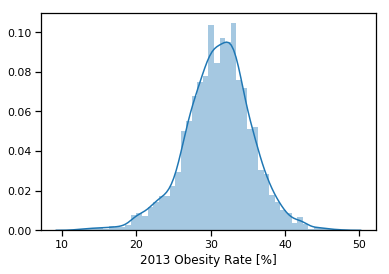

In [25]:
s = sns.distplot(master_df['PCT_OBESE_ADULTS13'].dropna())
s.set_xlabel('2013 Obesity Rate [%]')

Let's look at some other parameter distributions. There's a pretty remarkable spread in the population size of the county (also, look how log-symmetric!). Adult diabetes rate is the percentage of the population with age > 20 and gestational diabetes (different from types 1 and 2). Poverty rate is the percentage of the population with income below the poverty threshold, which varies by family size, age of the head of the household, etc. Low access to store is defined as the percentage of the population living > 1 mile (> 10 miles) from the nearest supermarket or grocery store in an urban (rural) area. The last distribution is moderately skewed to higher % of low access to store.

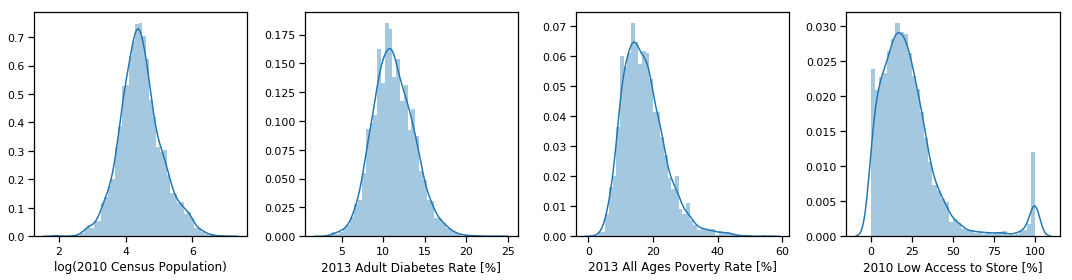

In [26]:
f, axes = plt.subplots(1,4,figsize=(15,4))
s = sns.distplot(np.log10(master_df['2010_CENSUS_POP'].dropna()), ax=axes[0])
s.set_xlabel('log(2010 Census Population)')
s = sns.distplot(master_df['PCT_DIABETES_ADULTS13'].dropna(), ax=axes[1])
s.set_xlabel('2013 Adult Diabetes Rate [%]')
s = sns.distplot(master_df['POVRATE13_ALL'].dropna(), ax=axes[2])
s.set_xlabel('2013 All Ages Poverty Rate [%]')
s = sns.distplot(master_df['PCT_LACCESS_POP10'].dropna(), ax=axes[3])
s.set_xlabel('2010 Low Access to Store [%]')
f.tight_layout()

In [27]:
min_pop_ind = master_df['2010_CENSUS_POP'].dropna().idxmin()
max_pop_ind = master_df['2010_CENSUS_POP'].dropna().idxmax()

print('According to the 2010 Census, county population ranges from ',
      master_df['COUNTY'][min_pop_ind], master_df['STATE'][min_pop_ind],':',
      int(min(master_df['2010_CENSUS_POP'].dropna())),
        'to', 
      master_df['COUNTY'][max_pop_ind], master_df['STATE'][max_pop_ind],':',
      int(max(master_df['2010_CENSUS_POP'].dropna())))

According to the 2010 Census, county population ranges from  Loving TX : 82 to Los Angeles CA : 9818605


We can also examine the prevalence of poverty broken down separately for metro/nonmetro counties and counties experiencing population loss over two decades.

Text(0.5, 1.0, 'Metro/Persistent Childhood Poverty')

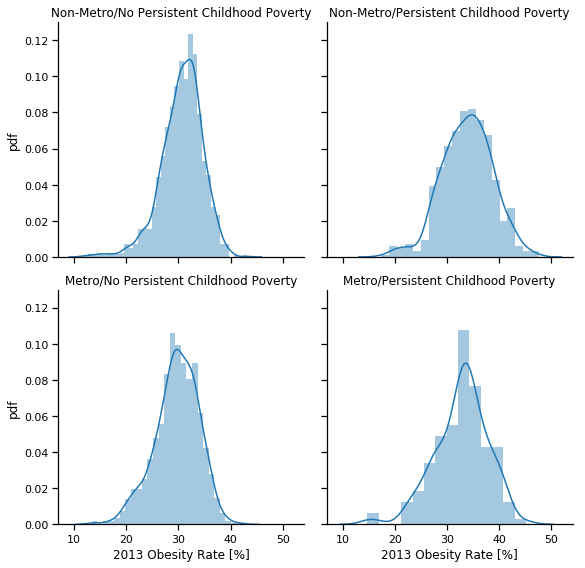

In [28]:
g = sns.FacetGrid(master_df, row='METRO13', col='PERCHLDPOV10', height=4)
g.map(sns.distplot, 'PCT_OBESE_ADULTS13').set_axis_labels("2013 Obesity Rate [%]", "pdf")
axes = g.axes.flatten()
axes[0].set_title("Non-Metro/No Persistent Childhood Poverty")
axes[1].set_title("Non-Metro/Persistent Childhood Poverty")
axes[2].set_title("Metro/No Persistent Childhood Poverty")
axes[3].set_title("Metro/Persistent Childhood Poverty")

Let's now move onto more explicitly examining relationships between FEA factors and poverty. There appear to be some interesting trends and insights buried in the data. The positive trend between poverty and obesity rate is not too surprising based on our prior public health knowledge. There isn't a strong trend between the availability of farmers markets and poverty rate, but FMs do tend to be more common amongst wealthier areas. The lack of strong correlation between the prevalence of FF restaurants and poverty rate is pretty surprising. Areas with the highest poverty rates tend to be places with fewer seniors.

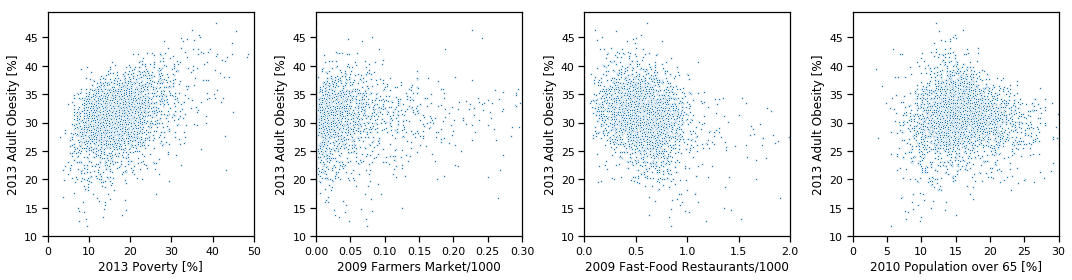

In [29]:
f, axes = plt.subplots(1,4,figsize=(15,4))
s = sns.scatterplot(y='PCT_OBESE_ADULTS13', x='POVRATE13_ALL', data=master_df, ax=axes[0], s=5)
s.set_xlabel('2013 Poverty [%]')
s.set_ylabel('2013 Adult Obesity [%]')
s.set_xlim(0,50)
s = sns.scatterplot(y='PCT_OBESE_ADULTS13', x='FMRKTPTH09', data=master_df, ax=axes[1], s=5)
s.set_xlabel('2009 Farmers Market/1000')
s.set_ylabel('2013 Adult Obesity [%]')
s.set_xlim(0,0.3)
s = sns.scatterplot(y='PCT_OBESE_ADULTS13', x='FFRPTH09', data=master_df, ax=axes[2], s=5)
s.set_xlabel('2009 Fast-Food Restaurants/1000')
s.set_xlim(0,2)
s.set_ylabel('2013 Adult Obesity [%]')
s = sns.scatterplot(y='PCT_OBESE_ADULTS13', x='PCT_65OLDER10', data=master_df, ax=axes[3], s=5)
s.set_xlabel('2010 Population over 65 [%]')
s.set_ylabel('2013 Adult Obesity [%]')
s.set_xlim(0,30)

f.tight_layout()

Although it may seem totally trivial, let's inspect poverty rate vs. median household income. As expected, there's a negative trend, but the exact form of this scatterplot is pretty interesting. The steep rise below the poverty rate of 10% implies that even in low-poverty areas, there's actually a large variability in the overall affluence of the population (ranging from ~40k to over 100k). Similarly, the long tail in the poverty rate beyond 10% implies that there are relevant factors beyond the median income alone. At a fixed poverty rate, counties with higher % of white population seems to have higher median household incomes.

Text(0, 0.5, '2013 Median Household Income')

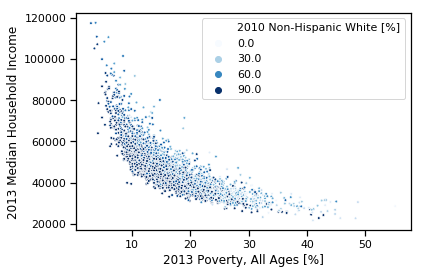

In [30]:
s = sns.scatterplot(x='POVRATE13_ALL', y='MEDHHINC13', hue='PCT_NHWHITE10', palette='Blues', hue_norm=(0,90), data=master_df, s=8)
legend = s.legend()
legend.texts[0].set_text("2010 Non-Hispanic White [%]")
s.set_xlabel('2013 Poverty, All Ages [%]')
s.set_ylabel('2013 Median Household Income')


Let's select a random subset of the counties and inspect the breakdown in race.

Text(0, 0.5, '2010 Population [%]')

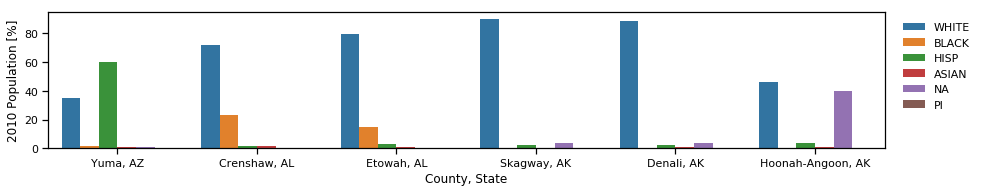

In [31]:
total_rows = np.shape(master_df)[1]
rand_ind = random.sample(range(1,287), 6)

plt.figure(figsize=(15,2.5))
race_df = master_df.iloc[rand_ind,:][['FIPS', 'STATE', 'COUNTY', 'PCT_NHWHITE10', 'PCT_NHBLACK10', 'PCT_HISP10', 'PCT_NHASIAN10', 'PCT_NHNA10', 'PCT_NHPI10']].copy()

race_df['COUNTY_STATE'] = race_df['COUNTY']+', '+race_df['STATE']
race_df = race_df.drop(columns=['FIPS', 'STATE', 'COUNTY'])

race_column_list = race_df.columns.drop('COUNTY_STATE')
race_df = race_df.rename(columns=lambda x: x.split('PCT_')[1].split('10')[0] if x in race_column_list else x)
race_column_list = race_df.columns.drop('COUNTY_STATE').drop('HISP')
race_df = race_df.rename(columns=lambda x: x.split('NH')[1] if x in race_column_list else x)

race_df = pd.melt(race_df, id_vars=['COUNTY_STATE'])
s = sns.barplot(x='COUNTY_STATE', y='value', hue='variable', data=race_df)
leg = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, frameon=False)

s.set_xlabel('County, State')
s.set_ylabel('2010 Population [%]') 

# Additional Prepwork

We have to do a few more things before we can throw the data at ML algorithms. We will also rename the data to X following the general convention, then split into training and test sets.

In [32]:
X = master_df.drop(axis=1, labels=['FIPS', 'STATE', 'COUNTY', 'PCT_OBESE_ADULTS08', 'PCT_OBESE_ADULTS13'])
    
columns_to_log = ['MEDHHINC13', '2010_CENSUS_POP', 'POP_EST_2011', 'POP_EST_2012', 'POP_EST_2013']
for c in columns_to_log:
    X = convert2log(c, X)
y = master_df['PCT_OBESE_ADULTS13']

In [33]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=11)

In [34]:
X_train.describe()

,POVRATE13_ALL,POVRATE13_CHILD,PCT_LACCESS_POP10,PCT_LACCESS_LOWI10,PCT_LACCESS_HHNV10,PCT_LACCESS_CHILD10,PCT_LACCESS_SENIORS10,GROCPTH09,SUPERCPTH09,CONVSPTH09,...,PCT_18YOUNGER10,PERPOV10,PERCHLDPOV10,METRO13,POPLOSS10,LOG10_MEDHHINC13,LOG10_2010_CENSUS_POP,LOG10_POP_EST_2011,LOG10_POP_EST_2012,LOG10_POP_EST_2013
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,...,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,17.328364,24.668818,23.315421,8.265581,3.105805,5.417240,3.877370,0.267994,0.015562,0.598391,...,23.365729,0.118182,0.235455,0.372273,0.170455,4.649127,4.456335,4.457149,4.456972,4.456968
std,6.762851,9.735446,20.025920,8.040788,2.647865,4.781306,4.155462,0.227178,0.021037,0.310552,...,3.326151,0.322897,0.424379,0.483520,0.376117,0.102697,0.624096,0.625797,0.627658,0.629231
min,3.000000,3.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.111539,0.000000,0.000000,0.000000,0.000000,4.333890,2.619093,2.640481,2.643453,2.629410
25%,12.400000,17.400000,10.601750,3.392157,1.626965,2.326342,1.562656,0.149913,0.000000,0.406375,...,21.364970,0.000000,0.000000,0.000000,0.000000,4.579458,4.047460,4.046466,4.046602,4.044148
50%,16.450000,24.000000,19.582397,6.134059,2.573493,4.406053,2.835992,0.206264,0.007145,0.548347,...,23.344353,0.000000,0.000000,0.000000,0.000000,4.642830,4.412444,4.414388,4.413266,4.412477
75%,21.200000,30.900000,29.459602,10.214310,3.816298,6.886496,4.519518,0.310318,0.025588,0.721957,...,25.036688,0.000000,0.000000,1.000000,0.000000,4.711181,4.813372,4.816455,4.818016,4.818539
max,55.100000,64.700000,100.000001,72.274456,50.178231,33.610607,29.146426,3.073770,0.256213,3.121748,...,40.126925,1.000000,1.000000,1.000000,1.000000,5.070703,6.992050,6.995129,6.997978,7.000670


Next, standardize the features so they are all on the same order of magnitude. Apply the same transformation to the test set.

In [35]:
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

## Feature Selection

We probably don't need all 70 columns to predict the obesity rate, as there are columns that contain very little predictive power (i.e., noise) or are redundant with one another. 

For the first problem, we can try powerful techniques like PCA to try to reduce the dimensionality, but in the process, PCA generates new features that are not very easy to interpret. With 70 columns, we're not really suffering from computational issues, so we won't focus too much on paring down on the # of features.

For the second problem, let's see if we can gain some insight from two of the ML algorithms, Linear Regression and Random Forest Regression.

The coefficients fit from linear regression can be interpreted in an intuitive way. Features with large coefficients influence the prediction, or our target variable, more strongly. Unfortunately, here the features that are dominating with the biggest coefficients are the population data, because they are highly correlated amongst themselves. We will need to do some smart feature selection to deal with these collinearities.

Text(0, 0.5, 'Coefficients')

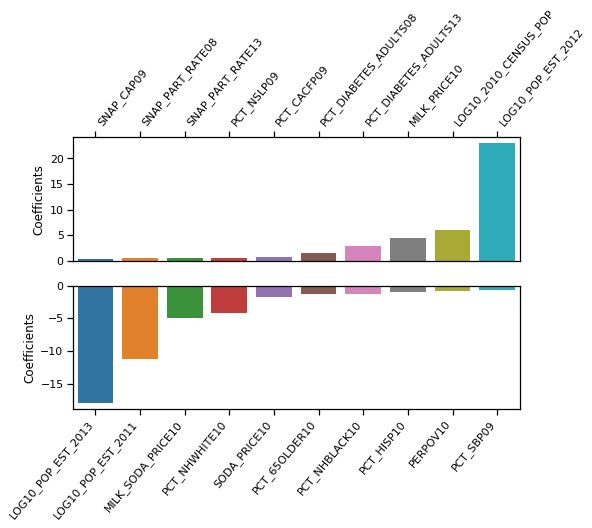

In [36]:
lr = LinearRegression()
lr.fit(X_scaled, y_train)

coef_neg = pd.Series(lr.coef_.reshape(-1,), index=X_scaled.columns).sort_values()[:10]
coef_pos = pd.Series(lr.coef_.reshape(-1,), index=X_scaled.columns).sort_values()[-10:]

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 5))
s = sns.barplot(x=coef_pos.index, y=coef_pos.values, ax=axes[0])
dummy = s.set_xticklabels(s.get_xticklabels(), rotation=50, ha='left')
s.set_ylabel('Coefficients')

axes[0].xaxis.set_ticks_position('top')
s = sns.barplot(x=coef_neg.index, y=coef_neg.values, ax=axes[1])
dummy = s.set_xticklabels(s.get_xticklabels(), rotation=50, ha='right')
s.set_ylabel('Coefficients')

Here's another way of inspecting feature importance with RF. This method doesn't appear to be strongly sensitive to collinearities in the data, as we do not see the population data appearing in the top 10. Unsurprisingly, diabetes rate seems to be a strong predictor of the obesity rate. Many of the other features in the top 10 are related to the restaurant industry.

/Users/jieunchoi/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


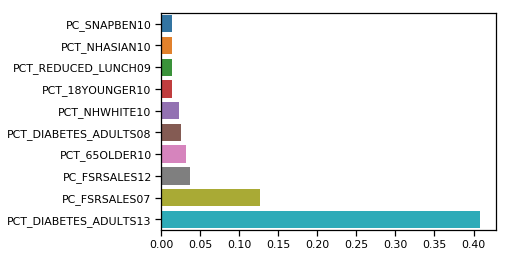

In [37]:
rf = RandomForestRegressor()
rf.fit(X_scaled, y_train)

feat_imp = rf.feature_importances_
feat_imp_ind = np.argsort(feat_imp)[-10:]

s = sns.barplot(x=feat_imp[feat_imp_ind], y=X_train.columns[feat_imp_ind])

## Dealing with Collinearity

We will remove feature columns with correlation coefficient > 0.6. We're using a handy code snippet taken directly from [here](https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/).

In [38]:
corr_matrix = X_scaled.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

In [39]:
X_scaled = X_scaled.drop(columns=to_drop, axis=1)
X_test = X_test.drop(columns=to_drop, axis=1) #apply to the test set also so we don't forget later!
X_scaled.head()

,POVRATE13_ALL,PCT_LACCESS_POP10,PCT_LACCESS_HHNV10,GROCPTH09,SUPERCPTH09,CONVSPTH09,SPECSPTH09,SNAPSPTH12,WICSPTH08,FFRPTH09,...,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,PCT_18YOUNGER10,PERPOV10,PERCHLDPOV10,METRO13,POPLOSS10,LOG10_2010_CENSUS_POP
1573,0.812500,0.141498,0.609795,-0.397385,-0.279239,0.294687,-0.523001,0.271296,-0.238812,-0.214735,...,-0.218055,1.322681,-0.643726,0.620716,0.029835,1.0,1.0,0.0,0.0,-0.343675
760,-0.539773,1.018532,-0.553079,-0.752311,0.437535,-0.768965,-0.013949,-0.749190,-0.637271,0.136269,...,1.024779,-0.199263,-0.115069,-0.624709,0.257894,0.0,0.0,1.0,0.0,1.048824
1902,-0.494318,0.146805,-0.460261,-0.294047,1.275201,-0.333187,0.558428,-0.281369,0.072179,0.763801,...,2.084840,-0.043463,0.300918,-0.841065,1.105480,0.0,0.0,1.0,0.0,1.094124
2131,1.585227,-0.679287,0.418206,0.378265,1.459493,-0.045846,-0.523001,0.536475,0.229981,-0.686105,...,0.144181,97.223519,-0.520171,-0.518391,1.274891,1.0,1.0,0.0,0.0,-0.074086
283,-0.119318,0.635286,-0.634048,-0.611245,0.513752,-0.623109,0.603359,-0.961243,-0.652333,0.348544,...,0.360210,0.729245,2.221486,-0.133125,0.049276,0.0,0.0,1.0,0.0,0.984518


Now redo the checks from above.

Text(0, 0.5, 'Coefficients')

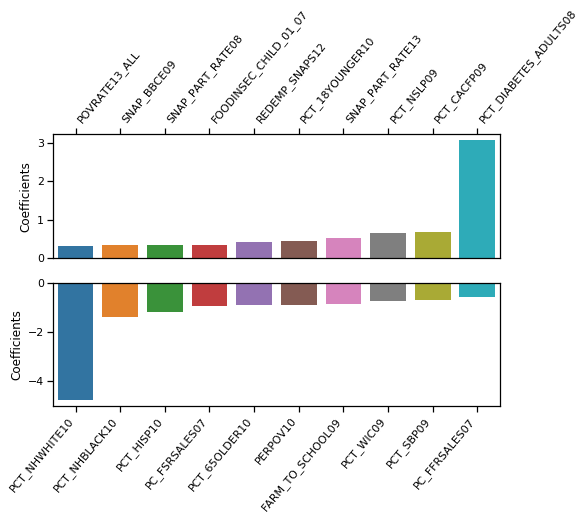

In [40]:
lr = LinearRegression()
lr.fit(X_scaled, y_train)

coef_neg = pd.Series(lr.coef_.reshape(-1,), index=X_scaled.columns).sort_values()[:10]
coef_pos = pd.Series(lr.coef_.reshape(-1,), index=X_scaled.columns).sort_values()[-10:]

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 5))
s = sns.barplot(x=coef_pos.index, y=coef_pos.values, ax=axes[0])
dummy = s.set_xticklabels(s.get_xticklabels(), rotation=50, ha='left')
s.set_ylabel('Coefficients')

axes[0].xaxis.set_ticks_position('top')
s = sns.barplot(x=coef_neg.index, y=coef_neg.values, ax=axes[1])
dummy = s.set_xticklabels(s.get_xticklabels(), rotation=50, ha='right')
s.set_ylabel('Coefficients')

/Users/jieunchoi/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


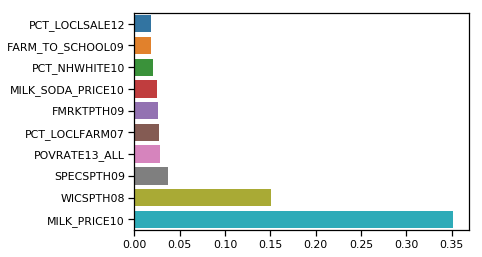

In [41]:
rf = RandomForestRegressor()
rf.fit(X_scaled, y_train)

feat_imp = rf.feature_importances_
feat_imp_ind = np.argsort(feat_imp)[-10:]

s = sns.barplot(x=feat_imp[feat_imp_ind], y=X_train.columns[feat_imp_ind])

# Training ML algorithms

## Establishing a Baseline

Before we proceed, let's first establish a baseline performance to compare with subsequent results. A very simple baseline guess is the median of the target values. 

In [42]:
def mse(y_true, y_pred):
    mse = np.mean((y_true-y_pred)**2.0)
    return mse

In [43]:
y_simple_guess = np.median(y_train)
print("MSE: {:3.2f}".format(mse(y_test, y_simple_guess)))

MSE: 21.16


We will test the following four ML algorithms.

- Linear Regression
- Gradient Boosting
- Random Forest
- Suppert Vector Machine

In [44]:
model_list = {'LR':LinearRegression(), 'KNN':KNeighborsRegressor(), \
              'GBR':GradientBoostingRegressor(), 'RF':RandomForestRegressor(), 'SVM':SVR()}

In [45]:
for m in model_list.keys():
    clf = model_list[m]
    clf.fit(X_scaled, y_train)
    y_pred = clf.predict(X_test)
    print(m+", MSE: {:3.2f}".format(mse(y_test, y_pred)))

LR, MSE: 7.58
KNN, MSE: 9.24
GBR, MSE: 6.15


/Users/jieunchoi/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, MSE: 7.04


/Users/jieunchoi/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM, MSE: 9.02


## Hyperparameter Tuning

To do.